# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Import library

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
import random
import config
import evaluation_vectorization as ev
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

# Random Seed

In [2]:
seed = 0

# Get Aging Model

In [3]:
with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device = 'cpu'
device

'cpu'

# Prepare data

## Dataset

In [5]:
if config.current_dataset is not None:
    ds = config.datasets[config.current_dataset]
else:
    ds = config.datasets[0]

ds

'Iris'

## Load data

In [15]:
datapath = os.path.join(os.getcwd(), 'Datasets',
                        'dataset_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([150, 4]), torch.Size([150]), 150, 4, 3)

## Pseudo-electrical Signal

In [16]:
X = X - torch.min(X, axis=0)[0]
X = X / (torch.max(X, axis=0)[0])
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [17]:
X[:10, :9]

tensor([[0.2222, 0.6250, 0.0678, 0.0417],
        [0.1667, 0.4167, 0.0678, 0.0417],
        [0.1111, 0.5000, 0.0508, 0.0417],
        [0.0833, 0.4583, 0.0847, 0.0417],
        [0.1944, 0.6667, 0.0678, 0.0417],
        [0.3056, 0.7917, 0.1186, 0.1250],
        [0.0833, 0.5833, 0.0678, 0.0833],
        [0.1944, 0.5833, 0.0847, 0.0417],
        [0.0278, 0.3750, 0.0678, 0.0417],
        [0.1667, 0.4583, 0.0847, 0.0000]])

In [18]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
valid_rate = 0.2
test_rate = 0.2
E_train = min(8192, int(E*train_rate))
E_valid = min(2048, int(E*valid_rate))
E_test = min(2048, int(E*test_rate))

random.seed(config.data_split_seed);
np.random.seed(config.data_split_seed);
torch.manual_seed(config.data_split_seed);

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_valid])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_valid-E_test])

len(train_data), len(valid_data), len(test_data)

(90, 30, 30)

In [19]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))

# Normal PNN

In [20]:
random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

## Define

In [21]:
PNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, config.N_Hidden, age_generator, xpu=device),
                         pnnv.PNNLayer(config.N_Hidden, N_class, age_generator, xpu=device))

PNN.apply(lambda z: pnnv.MakeModel(z, M=1))
PNN.apply(lambda z: pnnv.SetTime(z, t=[0]))

PNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Training

In [22]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=config.lr)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, valid_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, valid_loader,
                                                                   config.m, config.T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=50000, cache=ds)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.33333 | Loss: 1.006955385 |
| Epoch:   500 | Accuracy: 0.96667 | Loss: 0.195138738 |
| Epoch:  1000 | Accuracy: 0.96667 | Loss: 0.190932021 |
| Epoch:  1500 | Accuracy: 0.96667 | Loss: 0.198182568 |
| Epoch:  2000 | Accuracy: 0.96667 | Loss: 0.183945194 |
| Epoch:  2500 | Accuracy: 0.96667 | Loss: 0.177153483 |
| Epoch:  3000 | Accuracy: 0.96667 | Loss: 0.193312868 |
| Epoch:  3500 | Accuracy: 0.96667 | Loss: 0.197401986 |
| Epoch:  4000 | Accuracy: 0.96667 | Loss: 0.190450519 |
| Epoch:  4500 | Accuracy: 0.96667 | Loss: 0.194387510 |
| Epoch:  5000 | Accuracy: 0.96667 | Loss: 0.192255080 |
| Epoch:  5500 | Accuracy: 0.96667 | Loss: 0.201395705 |
| Epoch:  6000 | Accuracy: 0.96667 | Loss: 0.194890708 |
| Epoch:  6500 | Accuracy: 0.96667 | Loss: 0.202057332 |
| Epoch:  7000 | Accuracy: 0.96667 | Loss: 0.196619809 |
| Epoch:  7500 | Accuracy: 0.96667 | Loss: 0.194679260 |
| Epoch:  8000 | Accuracy: 0.96667 | Loss: 0.191359743 |
| Epoch:  8500 | Accuracy: 0.96

(11393, 0.1638822704553604)

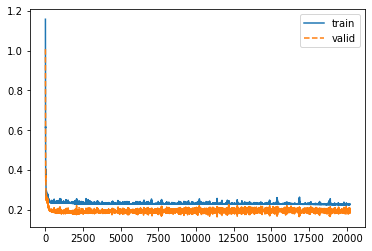

In [27]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(valid_loss_PNN, '--', label='valid')
plt.legend()
best = np.argmin(valid_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, valid_loss_PNN[best]

In [32]:
for p in PNN.parameters():
    print(p.abs().max())
    print(p.abs().min())

tensor(75.4667, grad_fn=<MaxBackward1>)
tensor(0.0008, grad_fn=<MinBackward1>)
tensor(19.3527, grad_fn=<MaxBackward1>)
tensor(0.0014, grad_fn=<MinBackward1>)


## Save Model

In [15]:
with open(f'./result/{ds}_PNN_{seed}.p', 'wb') as f:
    pickle.dump(PNN, f)